# Rat hexMaze Analysis
The objective of this script is to identify time intervals of interest in rat maze navigation for posterior analysis of neural data. 

The notebook examines a single rat session, exploring:
Speed profiles in each run, U-turns, and deviations or come-backs to optimal (shortest) paths.

In [58]:
## Import functions

import numpy as np  
import pandas as pd
np.set_printoptions(suppress=True) # Supress scientific notation when printing
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
import re # Regular expressions
import networkx as nx # Package for graph represenations 
from datetime import datetime, time 
import pygraphviz as gv

from networkx.drawing.nx_agraph import graphviz_layout, to_agraph, write_dot
from scipy.ndimage.filters import uniform_filter1d

In [104]:
## Set file names and paths

# Read full processed csv file and select rat and session

# SET CORRECT FILENAME!!!!!!!, since import date may differ!!!
filename = '../results/Rat_HM_Ephys_AggProc_20220202.csv'

data_full = pd.read_csv(filename)

# Select Rat and session of interest
selected_rat = 'Rat5'
selected_session = '2021-07-10'

selection = (data_full['rat_no'] == selected_rat) & (data_full['date'] == selected_session)
data = data_full.loc[selection]
# Set trial number as index for easy selecting trials
data.set_index('trial_no', inplace=True)

# Set datatype for node as string
data['node'] = data['node'].astype('str')

# Remove Speed artifacts (should be done better)
data['speed_ff'][data['speed_ff']>2]=0

data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 372 entries, 2 to 20
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   rat_no          372 non-null    object 
 1   date            372 non-null    object 
 2   rat_id          372 non-null    int64  
 3   node            372 non-null    object 
 4   time            372 non-null    object 
 5   distance        372 non-null    float64
 6   seconds_ff      372 non-null    float64
 7   speed_ff        372 non-null    float64
 8   island          372 non-null    object 
 9   re-visit        372 non-null    bool   
 10  u_turn          372 non-null    bool   
 11  cum_distance    372 non-null    float64
 12  cum_seconds     372 non-null    float64
 13  act_stps_2trgt  372 non-null    int64  
 14  min_stps_2trgt  372 non-null    int64  
 15  nd-visits-day   372 non-null    int64  
 16  nd-visits-rat   372 non-null    int64  
dtypes: bool(2), float64(5), int64(5), ob

/Users/federico/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/federico/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/federico/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._w

### Initial data exploration

#### Time to complete run

Average time to complete run was 41.6 s, with min of 16 and a max of 279 seconds. Trials that stand out as having unusually long times are: **Trial 2, 4**, starting at Easter I. and Hawaii respectively.

#### Speed profile

Plot speed histogram. The histogram seems to reveal two gaussian distributions, which could be interpreted as three speed phases:
1. **Initial acceleration/exploration:** from zero speed to 0.2 or 0.25
2. **Cruise speed:**  from 0.25 to 0.5 
3. **Super certain speed??:** A few extreme values, from 0.5 to 0.8

It's a bit tricky to draw strong conclusions such as these since it depends a lot on how many bins we use to plot the histograms. However, further data exploration below thus suggests that speed 2 occurs once the rat knows where it is going, and its trajectory coincides with optimal trajectory (shortest path). 

From the time to complete trial bar plot, it seems that there is a trend toward faster
trials as time goes by, at least for Japan and Hawaii.



count     18.000000
mean      61.862222
std       95.785263
min       21.120000
25%       24.260000
50%       34.020000
75%       48.540000
max      432.520000
Name: cum_seconds, dtype: float64


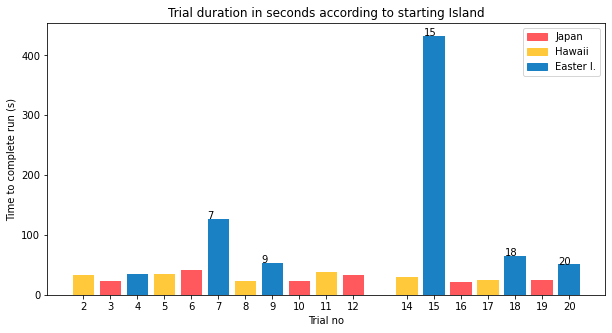

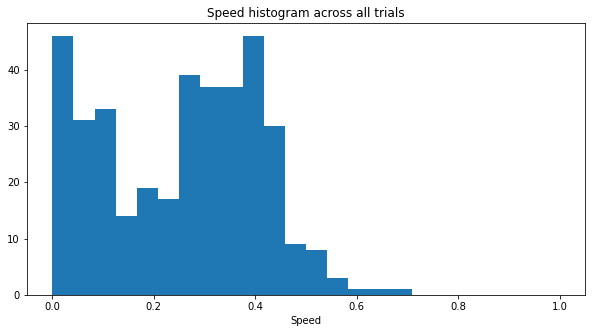

/Users/federico/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/federico/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/federico/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

Text(0.5, 1.0, 'Violin plots for speed according to starting island')

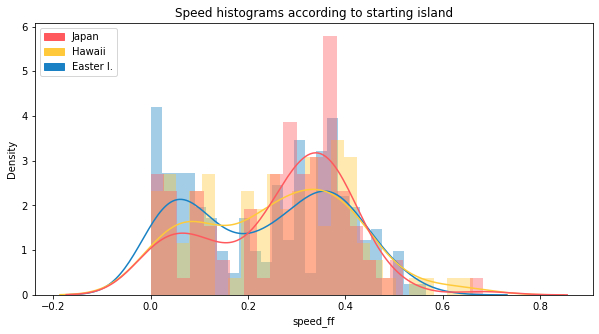

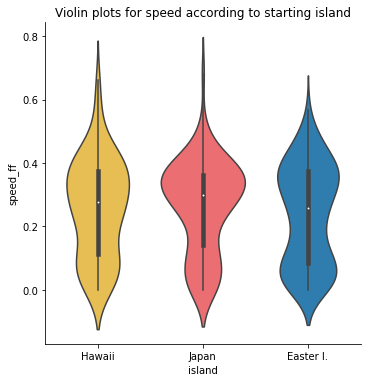

In [105]:
# Overall trial time exploration
# Print some data statistics
print(data.groupby('trial_no')['cum_seconds'].max().describe())

color_map = {'Japan': '#ff595e', 'Hawaii':'#ffca3a', 'Easter I.':'#1982c4', 'Ireland':'#8ac926 '}
color_map_rgb = {'Japan': (1, 0.35, 0.37), 'Hawaii':(1, 0.79, 0.23), \
                 'Easter I.':(0.1, 0.51, 0.77), 'Ireland':(0.54, 0.79, 0.15)}
starting_island = data.groupby('trial_no')['island'].first()
japan_trls = starting_island[starting_island=='Japan'].index
hawaii_trls = starting_island[starting_island=='Hawaii'].index
easter_trls =  starting_island[starting_island=='Easter I.'].index
ireland_trls =  starting_island[starting_island=='Ireland'].index

# Plot a scatter graph labeling longest trials
x = data.index.unique()
y = data.groupby('trial_no')['cum_seconds'].max()
ax = plt.bar(x=x, height=y, color = starting_island.map(color_map_rgb))
plt.title("Trial duration in seconds according to starting Island")
labels = list(color_map.keys())
handles = [plt.Rectangle((0,0),1,1, color=color_map_rgb[label]) for label in labels]
# Don't include last item of labels and handles, corresponding to target island IRELAND
# Since we're plotting starting island, and no trials start in the target island.
plt.legend(handles[:-1], labels[:-1])
plt.xticks(x)


# Annotate longest trials
tr_labels = [str(tr) if data.loc[tr,'cum_seconds'].max()>50 
          else "" for tr in data.index.unique() ] 
for i, txt in enumerate(tr_labels):
    plt.annotate(txt, (ax.patches[i].get_x(), y.tolist()[i]))
plt.ylabel('Time to complete run (s)')
plt.xlabel('Trial no')

plt.pause(0.5)

# Speed histogram
plt.hist(data['speed_ff'], bins=np.linspace(0,1,25));
plt.xlabel('Speed')
plt.title("Speed histogram across all trials")
plt.show()
sns.distplot(data.loc[easter_trls, 'speed_ff'], bins=25, color= '#1982c4')
sns.distplot(data.loc[hawaii_trls, 'speed_ff'], bins=25, color = '#ffca3a')
sns.distplot(data.loc[japan_trls, 'speed_ff'], bins=25, color = '#ff595e')
sns.distplot(data.loc[ireland_trls, 'speed_ff'], bins=25, color = '#ff597e')
plt.title("Speed histograms according to starting island")
plt.legend(handles[:-1], labels[:-1])

# Speed box plots according to island
sns.catplot(y = "speed_ff", x = starting_island, data = data, 
            kind = "violin", palette=color_map_rgb)
plt.title("Violin plots for speed according to starting island")

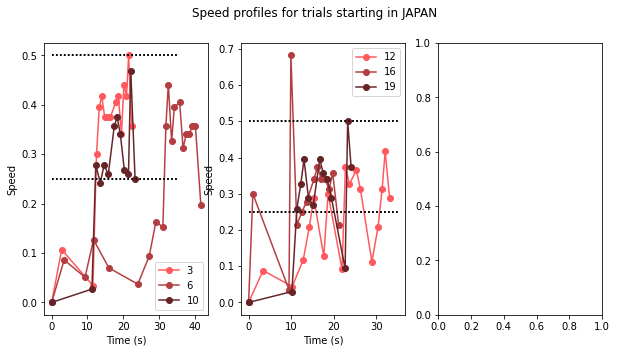

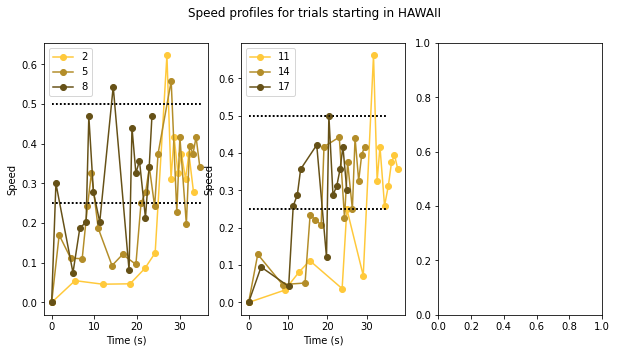

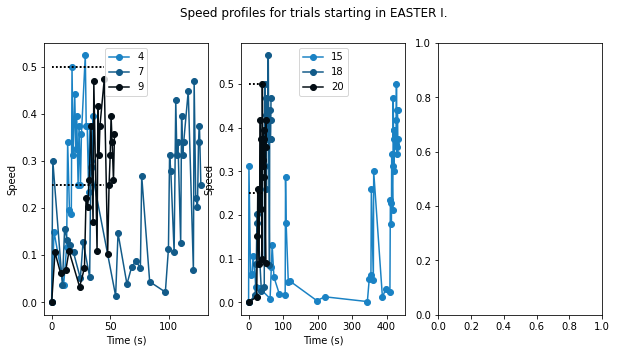

In [106]:
## Speed line plots with fewer trials per plot to have a better look

## JAPAN

nlines = 3
ncols = int(len(japan_trls)/nlines)
if ncols>0:
    it = 0
    colors = [color_map_rgb['Japan'], \
              tuple([0.7*x for x in color_map_rgb['Japan']]), \
              tuple([0.4*x for x in color_map_rgb['Japan']])]
    fig, ax = plt.subplots(1, ncols+1)
    for col in range(ncols):
        for line in range(nlines):
            tr = japan_trls[line+it]
            ax[col].plot(data.loc[tr, 'cum_seconds'], data.loc[tr, 'speed_ff'],\
                              label=str(tr), marker = 'o', color = colors[line]);
             #Add hypothetical speed phase boundaries
            ax[col].plot([0, 35], [0.25, 0.25], 'k:')
            ax[col].plot([0, 35], [0.5, 0.5], 'k:')
            ax[col].set_xlabel('Time (s)');
            ax[col].set_ylabel('Speed');
            ax[col].legend();
            if col == 2: break; # There are 7 trials in Japan, so third plot should only have 1 line
        it += nlines

    plt.suptitle('Speed profiles for trials starting in JAPAN')           
    plt.show()

## HAWAII
nlines = 3
ncols = int(len(hawaii_trls)/nlines)
if ncols>0:

    it = 0
    colors = [color_map_rgb['Hawaii'], \
              tuple([0.7*x for x in color_map_rgb['Hawaii']]), \
              tuple([0.4*x for x in color_map_rgb['Hawaii']])]

    fig, ax = plt.subplots(1, ncols+1)
    for col in range(ncols):
        for line in range(nlines):
            tr = hawaii_trls[line+it]
            ax[col].plot(data.loc[tr, 'cum_seconds'], data.loc[tr, 'speed_ff'],\
                              label=str(tr), marker = 'o', color=colors[line]);
             #Add hypothetical speed phase boundaries
            ax[col].plot([0, 35], [0.25, 0.25], 'k:')
            ax[col].plot([0, 35], [0.5, 0.5], 'k:')
            ax[col].set_xlabel('Time (s)');
            ax[col].set_ylabel('Speed');
            ax[col].legend();
            if col == 2: break; # There are 7 trials in Hawaii, so third plot should only have 1 line
        it += nlines
    plt.suptitle('Speed profiles for trials starting in HAWAII') 
    plt.show()

## EASTER I.
nlines = 3
ncols = int(len(easter_trls)/nlines)
if ncols>0:
    it = 0
    colors = [color_map_rgb['Easter I.'], \
              tuple([0.7*x for x in color_map_rgb['Easter I.']]), \
              tuple([0.1*x for x in color_map_rgb['Easter I.']])]

    fig, ax = plt.subplots(1, ncols+1)
    for col in range(ncols):
        for line in range(nlines):
            tr = easter_trls[line+it]
            ax[col].plot(data.loc[tr, 'cum_seconds'], data.loc[tr, 'speed_ff'],\
                              label=str(tr), marker = 'o', color = colors[line]);
             #Add hypothetical speed phase boundaries
            ax[col].plot([0, 45], [0.25, 0.25], 'k:')
            ax[col].plot([0, 45], [0.5, 0.5], 'k:')
            ax[col].set_xlabel('Time (s)');
            ax[col].set_ylabel('Speed');
            ax[col].legend();
            if (line == 1) & (col == 2): break;
        it += nlines
    plt.suptitle('Speed profiles for trials starting in EASTER I.') 
    plt.show()

## IRELAND 
nlines = 3
ncols = int(len(ireland_trls)/nlines)
if ncols>0:
    it = 0
    colors = [color_map_rgb['Easter I.'], \
              tuple([0.7*x for x in color_map_rgb['Easter I.']]), \
              tuple([0.1*x for x in color_map_rgb['Easter I.']])]

    fig, ax = plt.subplots(1, ncols+1)
    for col in range(ncols):
        for line in range(nlines):
            tr = ireland_trls[line+it]
            ax[col].plot(data.loc[tr, 'cum_seconds'], data.loc[tr, 'speed_ff'],\
                              label=str(tr), marker = 'o', color = colors[line]);
             #Add hypothetical speed phase boundaries
            ax[col].plot([0, 45], [0.25, 0.25], 'k:')
            ax[col].plot([0, 45], [0.5, 0.5], 'k:')
            ax[col].set_xlabel('Time (s)');
            ax[col].set_ylabel('Speed');
            ax[col].legend();
            if (line == 1) & (col == 2): break;
        it += nlines
    plt.suptitle('Speed profiles for trials starting in IRELAND.') 
    plt.show()

### U-turns and deviation from optimal (shortest) path

We will now look for U-turns and examine deviation from optimal (shortest path).

We find there are 6 u-turns, one in each trial: trial_nos: 2, 5, 10, 13, 16 and 24. U-turns always occur in starting island: In the bar chart, bar colour indicates starting island. In turn, each bar is annotated with the U-turn node and the island it belongs to. Both things co-incide.

We realise re-visiting a node could be an interesting moment, even if it is not an immediate u-turn. We look for duplicate nodes in the trajectory. Trials 2 and 4, which are also the longest, have several re-visits.

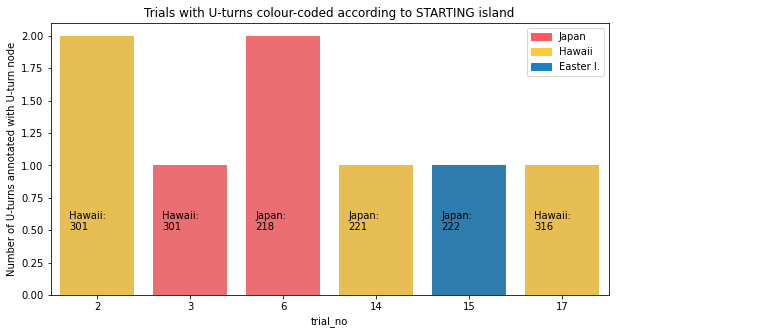

In [107]:
# Plot number of u-turns per trial.
# I need to reset index, so that trial_no is a standard column and I can plot it
u_turns = data[data['u_turn'] == True].reset_index()

sns.countplot(x='trial_no', data=u_turns,\
             palette = starting_island[u_turns['trial_no'].unique()].map(color_map_rgb).values)
plt.title('Trials with U-turns colour-coded according to STARTING island')
plt.ylabel('Number of U-turns annotated with U-turn node')
plt.legend(handles[:-1], labels[:-1])

# Annotate longest trials
tr_label_1 = u_turns['island'].to_list()
tr_label_2 = u_turns['node'].to_list()
for i, txt1 in enumerate(tr_label_1):
    txt = txt1 + ':\n' + tr_label_2[i]
    plt.annotate(txt, (i-0.3, 0.5))

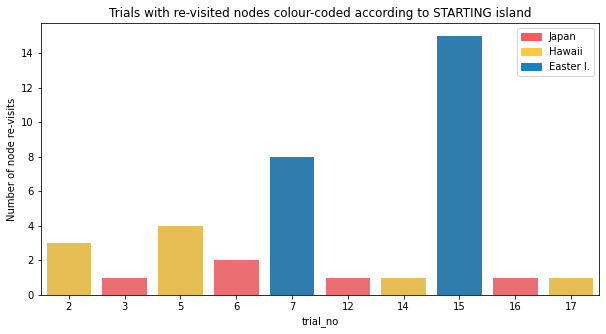

In [108]:
# Plot number of re-visits per trial.
# I need to reset index, so that trial_no is a standard column and I can plot it
re_visited = data[data['re-visit'] == True].reset_index()

sns.countplot(x='trial_no', data=re_visited, \
             palette = starting_island[re_visited['trial_no'].unique()].map(color_map_rgb).values)
plt.title('Trials with re-visited nodes colour-coded according to STARTING island')
plt.ylabel('Number of node re-visits')
plt.legend(handles[:-1], labels[:-1])

## Shortest distance plots

Some observations:

- In ***Trial 2***, rat seems pretty lost in Japan, although starting island is Easter. I.
- At bridges, rat seems to always speed-up

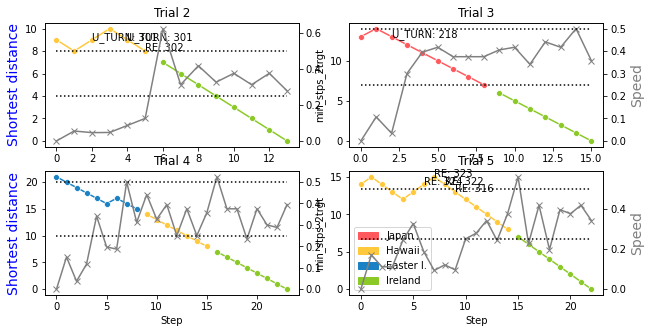

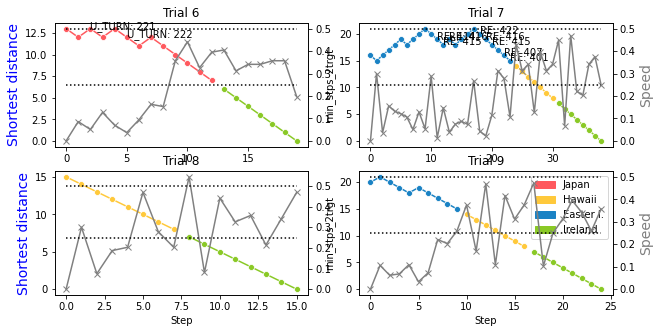

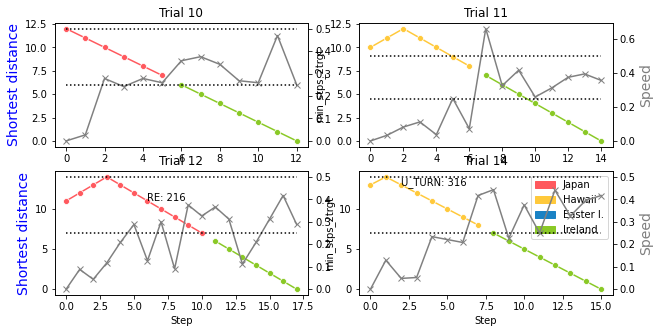

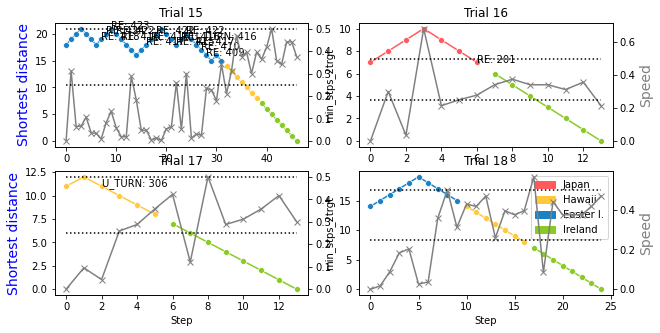

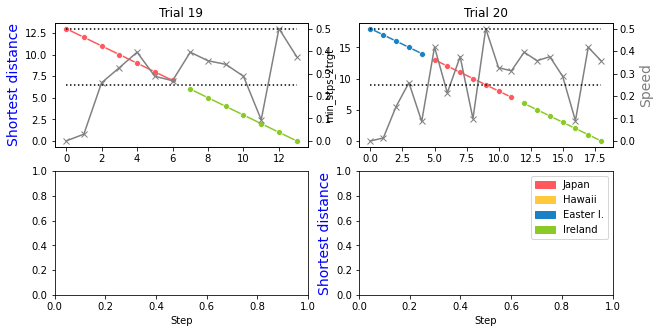

In [109]:
# Plot u_turns and re-visited nodes in shortest distance plots

# Generate list of labels to annotate plots
lbls = []
for i, node in enumerate(data['node'].astype('str')):
    if data.iloc[i]['u_turn']== True:
        lbls.append('U_TURN: ' + node)
    elif data.iloc[i]['re-visit'] == True:
        lbls.append('RE: ' + node)
    else:
        lbls.append("")

# Distribute plots in two columns
n_cols = 2
n_rows = 2 #int(len(data.index.unique())/n_cols +0.5) #(add 0.5 to round upwards)
n_tr = 0
tr = 0

while tr < data.index.unique().max():
    fig, ax = plt.subplots(n_rows, n_cols)
    plt.legend(handles, labels)
   
    for row in range(n_rows):
        for col in range(n_cols):
            if n_tr == len(data.index.unique()):
                break
            tr = data.index.unique()[n_tr]
            x = list(range(0, len(data.loc[tr])))
            y = data.loc[tr, 'min_stps_2trgt']

            sns.lineplot(ax=ax[row, col], x=x, \
                            y ='min_stps_2trgt', hue='island', marker = 'o',\
                            data = data.loc[tr], palette = color_map_rgb, label=str(tr), legend=False)
            
            trl_idx = [i for i, is_true in enumerate(data.index == tr) if is_true]
            for j, i in enumerate(trl_idx):
                ax[row, col].annotate(lbls[i], (x[j], y.iloc[j]))

            ax[row, col].set_title('Trial ' + str(tr))
            #ax[row, col].legend();

            ax2=ax[row, col].twinx()
            # make a plot with different y-axis using second axis object
            ax2.plot(x, data.loc[tr, 'speed_ff'], \
                           color="gray",marker="x")
            

            # Add hypothetical speed phase boundaries
            ax2.plot([0, max(x)], [0.25, 0.25], 'k:')
            ax2.plot([0, max(x)], [0.5, 0.5], 'k:')

            n_tr += 1
            
            
        ax2.set_ylabel("Speed", color="gray", fontsize=14)
        ax[row, col-1].set_ylabel('Shortest distance', color="blue",fontsize=14);
        
    ax[1, 0].set_xlabel('Step');
    ax[1, 1].set_xlabel('Step');
    


            #plt.show()
    
    
   
    #plt.pause(0.3)        
        

/Users/federico/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Deviation from optimal path coloured according to starting island')

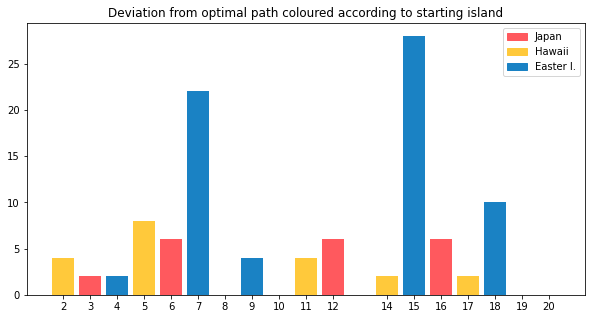

In [110]:
# Now plot deviation from shortest path for each trial as a bar graph, and add
# deviation value as a new column in dataframe

data['deviation'] = data['act_stps_2trgt'] - data['min_stps_2trgt']

x = data.index.unique()
y = data.groupby('trial_no')['deviation'].first()

plt.bar(x, y, color = starting_island.map(color_map_rgb))
plt.xticks(x)
plt.legend(handles[:-1], labels[:-1])
plt.title("Deviation from optimal path coloured according to starting island")
# I love that there seem to be cyclic oscillations in performance!!

In [111]:
edgelist_filename = '../data/graph_edgelist.dat'

### load graph
print("load graph")
G = nx.read_edgelist(edgelist_filename)  
print("graph: number of nodes = ",G.number_of_nodes(),", edges = ",G.number_of_edges())

### pre-compute all possible shortest path lengths and save in dictionary (does not save shortest paths itself)
DD = nx.shortest_path_length(G) 
DD = dict(DD)
print("dictionary: len =", len(DD), ", total items =", sum([len(dv) for dv in DD.values()]))

# get node positions from recosntructed graph 
pos = graphviz_layout(G)

load graph
graph: number of nodes =  96 , edges =  125
dictionary: len = 96 , total items = 9216


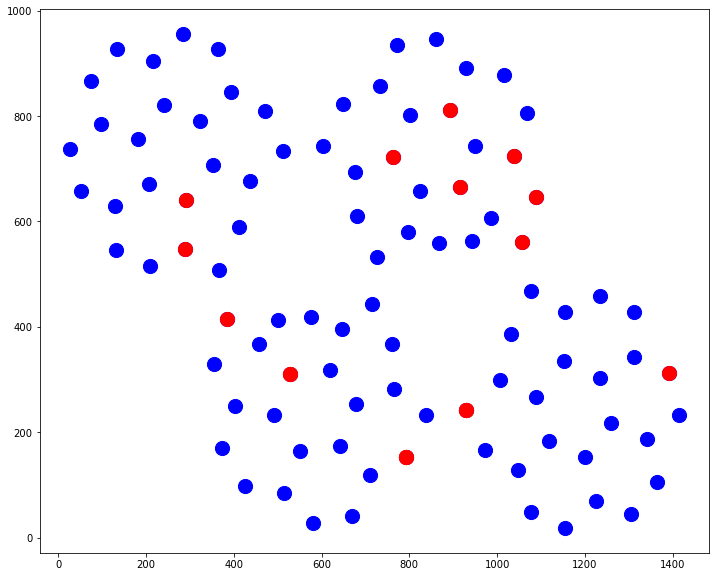

In [112]:
plt.figure(figsize=(12,10))

sp_th = 0.3

for nn in pos.keys():
    plt.scatter(pos[nn][0],pos[nn][1],s=200,c='b')




# Plot with node labels

for tr in data.index.unique():
    speed = data.loc[tr,'speed_ff']
    speed_tr = uniform_filter1d(speed,size=5)
    y = speed_tr
    f_nodes = np.argwhere(y>sp_th) 
    node_lbls = data.loc[tr,'node'].array
    if(len(f_nodes)>0):
        node_lbls = node_lbls[f_nodes[0]]  
        for nn in range(len(node_lbls)):
            plt.scatter(pos[str(node_lbls[nn])][0],pos[str(node_lbls[nn])][1],s=200,c='red')
plt.show() 


array([], shape=(0, 1), dtype=int64)

15
15
7
7
24
24
11
11
9
9
13
13
10
10
12
12
13
13
10
10
10
10
7
7
14
14
8
8
13
13
8
8
11
11
11
11
11
11
9
9
14
14
11
11
6
6
